In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [47]:
import numpy as np
X, y = np.array(mnist["data"]), (mnist["target"])
X.shape

(70000, 784)

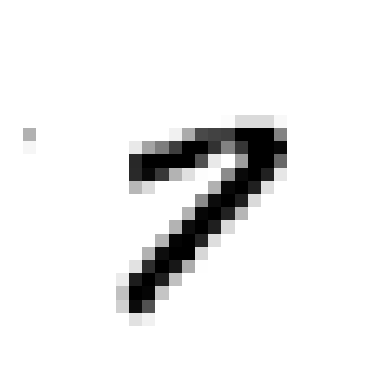

In [165]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[29]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
y = y.astype(np.uint8) # to convert entire list elements to any other data type, we use "astype"


In [53]:
# the data is already shuffeled in a way that last 10,000 images can be takes as test set
X_train_set = X[:60000]
X_test_set = X[60000:]
y_train_set = y[:60000]
y_test_set = y[60000:]

In [54]:
y_train_set

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: class, Length: 60000, dtype: uint8

In [55]:
# lets code a binary classifier (either it is or it is not)
y_train_5 = (y_train_set == 5) # return true or false array for each value
y_test_5 = (y_test_set == 5)

In [56]:
#Stochastic Gradient Descent Classifier, SGD Classifer

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_set, y_train_5)

SGDClassifier(random_state=42)

In [65]:

(X[65000]).shape


(784,)

In [68]:
# implementing Cross Valodation (Stratified K Fold)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# The stratified K  Fold class creates folds that contain a representataive ration of each class. 
# At each iteration, we clone the classifier, then train it on the "fold" data, then test it on testing fold
# then it counts no of correct predictions an outputs the ratio of correct predictions
#
# for binary classifier wheter it is "5" or not
for train_index, test_index in skfolds.split(X_train_set, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train_set[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_folds = X_train_set[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)

    y_pred = clone_clf.predict(X_test_folds)

    n_correct = sum(y_pred == y_test_folds)

    print(n_correct / len(y_pred)) # ratio of correct prediction

    

0.9646666666666667
0.9633333333333334
0.9703333333333334
0.9521666666666667
0.9518333333333333
0.9601666666666666
0.9728333333333333
0.9676666666666667
0.9661666666666666
0.9665


In [ ]:
from sklearn.base import BaseEstimator

## this is basically a classifier we coded that on predicting, returns False, means it always says regardless of the data given to it, that it is NOT a 5
## and this quote unquote "Classifier" is correct 90% of the time.. means that the data is skewed

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [73]:
never_5_clf = Never5Classifier()
from sklearn.model_selection import cross_val_score

c = cross_val_score(never_5_clf, X_train_set, y_train_5, cv=3, scoring="accuracy")
print(c)

[0.91125 0.90855 0.90915]


### Confusion Matrix

The general idea is to count the number of time the classifer confused instances of class A as class B.
For Ex, to know the number of times the classifer confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

In [74]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_set, y_train_5, cv=3) ## performs K Fold Cross valudation


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_5, y_train_pred)



In [78]:
conf_matrix

# first row of this matrix considers non 5 images(negative class), 687 are false positives, 53892 are true negative
# second row consider the images of 5s (the positive class), 1891 are false negatives (wrongly classififed), while the remaining 3530 are correctly classified (true positives)

array([[53892,   687],
       [ 1891,  3530]])

In [77]:
# in perfect classifier, we will have non zero values only in diagonal..
y_train_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect)


array([[54579,     0],
       [    0,  5421]])

### An important metric - Precision of Classifier

precision = TP / TP + FP

TP --> TRUE Positives
FP --> False POSITIVES



### Another important metric - Recall

recall = TP / TP + FN
FN = false negative


in our above matrix,
precision = 0.65
recall = 0.83



In [ ]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5, y_train_pred)
reca_score = recall_score(y_train_5, y_train_pred)

print("Precision Score", prec_score) ## should be near to 1
print("Recall Score", reca_score)## should be near to 1



Precision Score 0.8370879772350012
Recall Score 0.6511713705958311


In [83]:
TN, TP = conf_matrix[0][0], conf_matrix[1][1]
FN, FP = conf_matrix[1][0], conf_matrix[0][1]



In [87]:
calc_prec_score = TP / (TP + FP)
calc_recall_score = TP / (TP + FN)

false_positive_rate = FP / (FP + TN)

In [89]:
false_positive_rate #very less wrong numbers are being identified as 5 (here only "6" is identified) only once case

np.float64(0.012587258835815972)

In [90]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [ ]:
# y_scores = sgd_clf.decision_function([X[0]]) # default threshold is 0, if score is positive then it classifies as True else False in SGD

In [ ]:
decision_scores = cross_val_predict(sgd_clf, X_train_set, y_train_5, cv=3, method="decision_function") # returns the decision scores 

In [118]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, decision_scores)

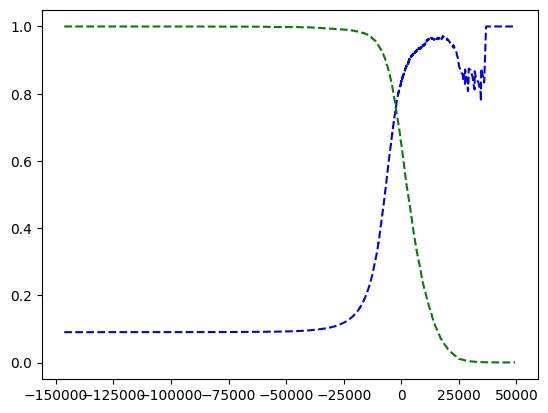

In [130]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--",  label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [132]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

np.float64(3370.019499144183)

In [ ]:
precision_score()

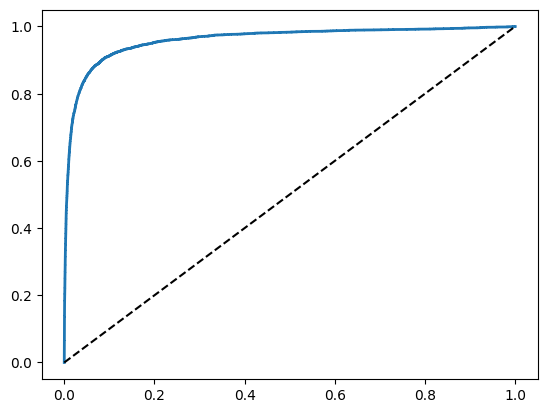

In [148]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, decision_scores)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0,1], [0,1], 'k--')


plot_roc_curve(fpr, tpr)

In [139]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, decision_scores)

np.float64(0.9604938554008616)

In [140]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# WE USE CROSS VAL PRODUCT BECAUSE IT TRAINS THE "CLASSIFIER" by K Fold Stratified training type shi 
y_probas_forest = cross_val_predict(forest_clf, X_train_set, y_train_5, cv=3, method="predict_proba")

In [143]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of postiive classss 

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)


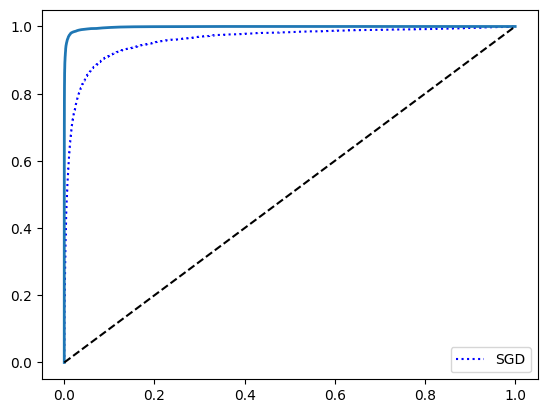

In [149]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest)
plt.legend(loc="lower right")
plt.show()

#### From the Above ROC Curve
It is quite clear the AUC of Random Forest > AUC of SGD Classifier 

##### Measuring Precision and Recall Scores for RandomForestClassifier

In [150]:
y_predict_forest = cross_val_predict(forest_clf, X_train_set, y_train_5, cv=3, method="predict")

### How to do Multiclass classification????

actually, there is no explicit ninja techniquie for multiclass classification!! it is basically a extended version of binary classification.

There are two ways:
1. One Versus Rest (O-v-R)
2. One Versus One (O-v-O)


###### One Versus Rest
For this dataset (MNNIST), to classifiy in which class a digit lies (0-9), there can be 10 classes, so you can train 10 classifiers, like 0's classifer, 1's classifer, 2's classifier etc and then mark the digit with the higest score from the given classifiers. 

###### One Versus One
In this, you can make comparisions, like 1 vs 2, 2 vs 3... like that, the problem is, here you need to pass image to 10C2 classifiers, that is 45 classifiers !!!!

SVM Scale poorly with this

### For most binary classification algorithms, however, OvR is preferred.


In [ ]:
# using support vector machine



from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train_set, y_train_set) ## By default, it uses One Vs One



ValueError: Expected 2D array, got 1D array instead:
array=[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  49. 238. 253. 253. 253. 253. 253.
 253. 253. 253. 251.  93.  82.  82.  56.  39.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  18. 219. 253. 253. 253. 253. 253.
 198. 182. 247. 241.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  80. 156. 107. 253. 253. 205.
  11.   0.  43. 154.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  14.   1. 154. 253.  90.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 139. 253. 190.
   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  11. 190. 253.
  70.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  35. 241.
 225. 160. 108.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  81.
 240. 253. 253. 119.  25.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  45. 186. 253. 253. 150.  27.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  16.  93. 252. 253. 187.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 249. 253. 249.  64.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  46. 130. 183. 253. 253. 207.   2.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  39. 148.
 229. 253. 253. 253. 250. 182.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  24. 114. 221. 253.
 253. 253. 253. 201.  78.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  23.  66. 213. 253. 253. 253.
 253. 198.  81.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  18. 171. 219. 253. 253. 253. 253. 195.
  80.   9.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  55. 172. 226. 253. 253. 253. 253. 244. 133.  11.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 136. 253. 253. 253. 212. 135. 132.  16.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [159]:
# To use One vs rest classifier, 

from sklearn.multiclass import OneVsRestClassifier

ovr_clf= OneVsRestClassifier(SVC())
ovr_clf.fit(X_train_set, y_train_set)

OneVsRestClassifier(estimator=SVC())

In [166]:
ovr_clf.predict([X[29]])

array([7], dtype=uint8)

In [169]:
classes = ovr_clf.classes_
estimators = ovr_clf.estimators_

In [172]:
# you can use SGD Classifier / RandomForestClassifier

sgd_clf.fit(X_train_set, y_train_set)



SGDClassifier(random_state=42)

In [173]:
sgd_clf.decision_function([some_digit])

array([[-19952.61876422,   -590.3567115 ,  -7972.75240113,
         -3478.55601736,  -7262.45840033, -11125.22184297,
        -10646.61127182,   4374.67764735,     65.16784009,
         -2192.38205227]])

In [174]:
cross_val_score(sgd_clf, X_train_set, y_train_set, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [175]:
## you can use standard scaler to futher improve it

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_set.astype(np.float64))

In [176]:
cross_val_score(sgd_clf, X_train_scaled, y_train_set, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [178]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train_set, cv=3) 
conf_mx = confusion_matrix(y_train_set, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

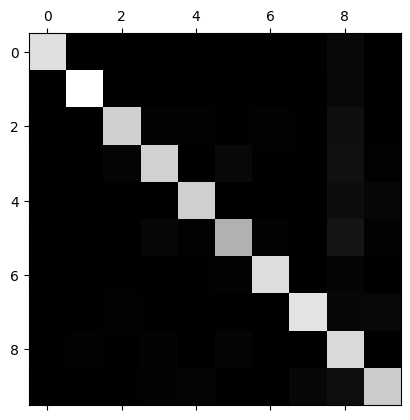

In [181]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [183]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [185]:
norm_conf_mx

array([[0.        , 0.        , 0.00371433, 0.00084417, 0.00135067,
        0.00725983, 0.006078  , 0.001013  , 0.03798751, 0.00016883],
       [0.        , 0.        , 0.00548799, 0.00355977, 0.0005933 ,
        0.00652625, 0.0005933 , 0.00103827, 0.03144468, 0.00148324],
       [0.00453172, 0.00453172, 0.        , 0.01544142, 0.01225243,
        0.00453172, 0.01124538, 0.0060423 , 0.06344411, 0.00184626],
       [0.00358832, 0.00277279, 0.01908335, 0.        , 0.00032621,
        0.03311042, 0.00440385, 0.00652422, 0.06573153, 0.0119067 ],
       [0.00205409, 0.00239644, 0.00701814, 0.00154057, 0.        ,
        0.00205409, 0.00581992, 0.0046217 , 0.05939747, 0.02807258],
       [0.00498063, 0.00276702, 0.00553403, 0.03099059, 0.00977679,
        0.        , 0.01383509, 0.00258255, 0.09869028, 0.01106807],
       [0.00506928, 0.00253464, 0.00709699, 0.00050693, 0.00743494,
        0.01639067, 0.        , 0.00050693, 0.02213586, 0.00016898],
       [0.00335196, 0.00159617, 0.0081404

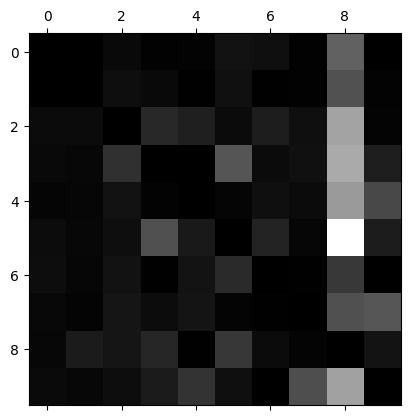

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray) ### rows represent "actuall" classes ### columns represent "predicted" classes

### Multilabel Classification

In [189]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train_set >= 7)
y_train_odd = (y_train_set % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [190]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_set, y_multilabel)


KNeighborsClassifier()

In [193]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [194]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_set, y_multilabel, cv=3)


In [209]:
from sklearn.metrics import f1_score

f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

0.9764102655606048

## Multioutput Classification

In [210]:
noise = np.random.randint(0,100, (len(X_train_set), 784))
X_train_mod = X_train_set + noise
noise = np.random.randint(0,100, (len(X_test_set), 784))
X_test_mod = X_test_set + noise
y_train_mod = np.copy(X_train_set)
y_test_mod = np.copy(X_test_set)


In [219]:
def plot_digit(some_digit):
    some_digit_image = some_digit.reshape(28, 28)

    plt.imshow(some_digit_image, cmap="binary")
    plt.axis("off")
    plt.show()
    # y = y.astype(np.uint8) # to

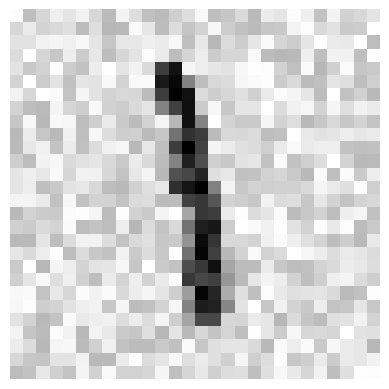

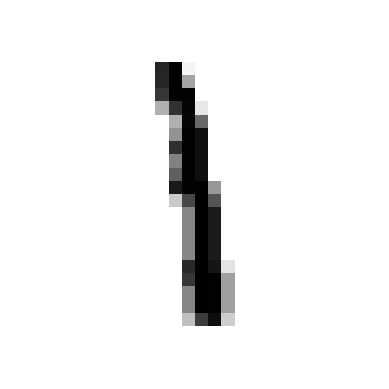

In [220]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plot_digit(X_test_mod[29])
plot_digit(y_test_mod[29])



In [214]:
knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf.predict([X_test_mod[1]])
   

KNeighborsClassifier()

In [215]:
clean_digit = knn_clf.predict([X_test_mod[29]])

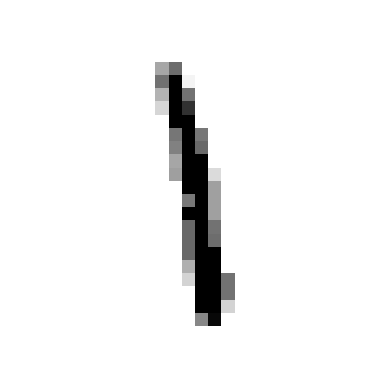

In [221]:
plot_digit(clean_digit)